In [27]:
!pip install yellowbrick
import yellowbrick
from pathlib import Path
import pendulum
import dill
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import clone 
from sklearn.feature_selection import RFECV
import seaborn as sns
import xgboost as xgb
import missingno as msno
import pandas as pd
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor  
from sklearn import set_config
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder, OneHotEncoder
import shap
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from scipy.stats import loguniform, uniform
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
from loguru import logger
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, GradientBoostingRegressor
pd.set_option("display.max_columns", None)


warnings.filterwarnings('ignore')



Defaulting to user installation because normal site-packages is not writeable


In [28]:
EXECUTION_DATE = pendulum.now(tz="UTC")
ROOT_DIR = Path().cwd()
MODEL_DIR = Path(ROOT_DIR, "models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)
logger.info(f"Model directory: {MODEL_DIR}")


2025-05-08 03:52:50.348 | INFO     | __main__:<module>:5 - Model directory: C:\Users\HP\Desktop\S4\Machine_Learning\models


In [29]:
# 1. Chargement et analyse initiale des données
def load_and_analyze_data(file_path):
    """
    Charge les données et effectue une analyse initiale
    """
   
    data = pd.read_csv(file_path, na_values=['?'])
    data.columns = data.columns.str.replace("-", "_")

    print("Informations sur le dataset:")
    print(data.info())
    print("\nAperçu des 5 premières lignes:")
    print(data.head())
    print("\nStatistiques descriptives:")
    print(data.describe(include='all'))
    
    missing_values = data.isnull().sum()
    print("\nValeurs manquantes par colonne:")
    print(missing_values[missing_values > 0])
    
    return data



In [30]:
# 3. Analyse exploratoire des données (EDA)
def perform_eda(data):
    """
    Réalise une analyse exploratoire des données
    """
    # Distribution du prix
    plt.figure(figsize=(10, 6))
    sns.histplot(data['price'].dropna(), kde=True)
    plt.title('Distribution du prix des voitures')
    plt.xlabel('Prix')
    plt.ylabel('Fréquence')
    plt.savefig('price_distribution.png')
    plt.close()
    
    # Relation entre variables numériques et prix
    numerical_features = ['wheel_base', 'length', 'width', 'height', 'curb_weight', 
                         'engine_size', 'bore', 'stroke', 'compression_ratio', 
                         'horsepower', 'peak_rpm','symboling', 'city_mpg', 'highway_mpg']
    
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(numerical_features[:9]):
        plt.subplot(3, 3, i+1)
        plt.scatter(data[feature], data['price'], alpha=0.5)
        plt.title(f'Prix vs {feature}')
        plt.xlabel(feature)
        plt.ylabel('Prix')
    plt.tight_layout()
    plt.savefig('price_vs_features.png')
    plt.close()
    
    # Matrice de corrélation
    numeric_df = data.select_dtypes(include=['int64', 'float64'])
    plt.figure(figsize=(12, 10))
    correlation_matrix = numeric_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Matrice de corrélation des variables numériques')
    plt.savefig('correlation_matrix.png')
    plt.close()
    
    # Distribution des prix par marque
    plt.figure(figsize=(14, 8))
    brand_avg_price = data.groupby('make')['price'].mean().sort_values(ascending=False)
    sns.barplot(x=brand_avg_price.index, y=brand_avg_price.values)
    plt.title('Prix moyen par marque')
    plt.xticks(rotation=90)
    plt.xlabel('Marque')
    plt.ylabel('Prix moyen')
    plt.savefig('avg_price_by_brand.png')
    plt.close()
    
    return data, correlation_matrix

In [31]:
# 4. Traitement des valeurs manquantes et aberrantes
def handle_missing_and_outliers(data, price_col='price', threshold=0.7, show_plots=True):
    """
    Traite les valeurs manquantes et aberrantes de manière complète
    
    Args:
        data (pd.DataFrame): DataFrame contenant les données
        price_col (str): Nom de la colonne cible (prix)
        threshold (float): Seuil pour supprimer les colonnes trop manquantes (0-1)
        show_plots (bool): Afficher les visualisations si True
    
    Returns:
        pd.DataFrame: DataFrame nettoyé
        dict: Statistiques de nettoyage
    """
    # Initialisation des statistiques
    stats = {
        'missing_before': data.isnull().sum().sum(),
        'outliers_detected': {},
        'columns_dropped': []
    }
    
    # 1. Visualisation des valeurs manquantes
    if show_plots:
        plt.figure(figsize=(15, 5))
        msno.matrix(data)
        plt.title('Distribution des Valeurs Manquantes', pad=20)
        plt.show()
    
    # 2. Suppression des colonnes avec trop de valeurs manquantes
    cols_to_drop = data.columns[data.isnull().mean() > threshold]
    if not cols_to_drop.empty:
        stats['columns_dropped'] = cols_to_drop.tolist()
        data = data.drop(columns=cols_to_drop)
        print(f"Colonnes supprimées (>{threshold*100}% manquants): {list(cols_to_drop)}")

    
    # 3. Détection et traitement des outliers pour toutes les variables numériques
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
    
    for col in numeric_cols:
        q1 = data[col].quantile(0.25)
        q3 = data[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        
        # Détection des outliers
        outliers_mask = (data[col] < lower) | (data[col] > upper)
        n_outliers = outliers_mask.sum()
        
        if n_outliers > 0:
            stats['outliers_detected'][col] = {
                'count': n_outliers,
                'percentage': n_outliers / len(data) * 100,
                'method': 'IQR'
            }
            
            # Remplacement des outliers par NaN
            data[col] = np.where(outliers_mask, np.nan, data[col])
    
    # 4. Traitement spécial pour la variable cible (price)
    if price_col in data.columns:
        q1 = data[price_col].quantile(0.25)
        q3 = data[price_col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        # Visualisation des outliers pour price
        if show_plots:
            plt.figure(figsize=(10, 6))
            sns.boxplot(x=data[price_col].dropna())
            plt.title('Distribution du prix avec limites des outliers', pad=15)
            plt.axvline(lower_bound, color='r', linestyle='--', label='Limite inférieure')
            plt.axvline(upper_bound, color='r', linestyle='--', label='Limite supérieure')
            plt.legend()
            plt.show()
            
            # Boxplot pour toutes les variables numériques
            plt.figure(figsize=(15, 8))
            sns.boxplot(data=data[numeric_cols])
            plt.xticks(rotation=45)
            plt.title('Distribution des variables numériques après traitement', pad=15)
            plt.tight_layout()
            plt.show()
    
    # 5. Statistiques finales
    stats['missing_after'] = data.isnull().sum().sum()
    stats['remaining_columns'] = list(data.columns)
    
    print(f"\nRésumé du nettoyage:")
    print(f"- Valeurs manquantes initiales: {stats['missing_before']}")
    print(f"- Valeurs manquantes après traitement: {stats['missing_after']}")
    print(f"- Colonnes supprimées: {stats['columns_dropped'] or 'Aucune'}")
    print("\nDétection des outliers:")
    for col, info in stats['outliers_detected'].items():
        print(f"- {col}: {info['count']} outliers ({info['percentage']:.2f}%)")
    
    # Sauvegarde des données nettoyées
    data['price_original'] = data.get(price_col, np.nan)
    return data, stats

In [32]:
# 5. Feature Engineering
def perform_feature_engineering(data):
    """
    Crée de nouvelles variables à partir des variables existantes
    """
    cylinder_mapping = {
        'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'eight': 8, 'twelve': 12
    } 
    data['num_cylinders'] = data['num_of_cylinders'].map(cylinder_mapping)
    
    num_of_doors_mapping = {'two': 2, 'four': 4}
    data['num_of_doors'] = data['num_of_doors'].map(num_of_doors_mapping)
        
    data['price_log'] = np.log1p(data['price'])
    
    
    return data

In [33]:
# 6. Préparation pour la modélisation
def prepare_for_modeling(data):
    """
    Prépare les données pour la modélisation
    """
    y = data['price_log']
    
    features = [
        'symboling', 'make', 'fuel_type', 'aspiration', 'num_of_doors', 
        'body_style', 'drive_wheels', 'wheel_base', 'length', 'width', 
        'height', 'curb_weight', 'engine_type', 'engine_size', 'bore', 'stroke',
        'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg', 'highway_mpg',
        'fuel_system', 'num_cylinders', 'engine_location', 'normalized_losses', 
         
    ]
    
    existing_features = [f for f in features if f in data.columns]
    X = data[existing_features] 
    X = X[~y.isna()]
    y = y[~y.isna()]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print(f"\nDimensions de X_train: {X_train.shape}")
    print(f"Dimensions de X_test: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test, existing_features

In [34]:
# 7.Création du pipeline
def create_pipeline(X_train):
    """Pipeline amélioré avec corrections des erreurs"""
    
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=42)),
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_regression, k='all'))
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='drop'
    )
    
    models = {
        'Ridge': RidgeCV(alphas=np.logspace(-3, 3, 100)),
        'Lasso': LassoCV(alphas=np.logspace(-4, 2, 50), cv=5, random_state=42),
        'RandomForest': RandomForestRegressor(
            n_estimators=200,
            max_depth=10,
            min_samples_leaf=10,
            random_state=42,
            n_jobs=-1
        ),
        'LinearRegression': LinearRegression(),
        'DecisionTree': DecisionTreeRegressor(
            max_depth=6,
            min_samples_leaf=10,
            random_state=42
        ),
        'KNN': KNeighborsRegressor(n_neighbors=5),
        
        'HistGradientBoosting': HistGradientBoostingRegressor(
            max_iter=200,
            learning_rate=0.05,
            max_depth=3,
            min_samples_leaf=15,
            l2_regularization=0.2,
            random_state=42
        ),
        'XGBoost': XGBRegressor(
            n_estimators=300,
            max_depth=4,
            learning_rate=0.05,
            reg_alpha=0.2,
            reg_lambda=1.0,
            early_stopping_rounds=10,
            random_state=42
        )
    }
    
    # 5. Construction des pipelines optimisés
    pipelines = {}
    for name, model in models.items():
        steps = [
            ('preprocessor', preprocessor),
            ('model', model)
        ]
        
        # Ajout de RFECV seulement pour les modèles linéaires
        if name in ['Ridge', 'Lasso', 'LinearRegression']:
            steps.insert(1, ('feature_selector', RFECV(
                estimator=model,
                step=5,
                cv=3,
                scoring='neg_mean_squared_error',
                n_jobs=-1
            )))
        
        pipelines[name] = Pipeline(steps)
    return pipelines, preprocessor, numeric_features, categorical_features

In [35]:
# 8.Evaluation et optimisation des modèles
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def evaluate_and_optimize_models(pipelines, X_train, X_test, y_train, y_test):
    """
    Évalue et optimise les modèles avec gestion spéciale pour XGBoost,
    correction pour véhicules premium et comparaison des performances.
    """
    all_results = {}
    results = []
    
    print("📊 Début de l'évaluation des modèles...")

    for name, pipeline in pipelines.items():
        print(f"\n🔍 Traitement du modèle {name}...")
        
        try:
            # Gestion spéciale pour XGBoost
            if 'XGB' in name or 'XGBoost' in name:
                # 1. Créer une copie du preprocessor
                preprocessor = clone(pipeline.named_steps['preprocessor'])
                
                # 2. Préparer les données transformées
                X_train_transformed = preprocessor.fit_transform(X_train, y_train)
                X_test_transformed = preprocessor.transform(X_test)
                
                # 3. Configurer XGBoost avec early stopping
                model = XGBRegressor(
                    n_estimators=1000,  # Nombre élevé car early stopping activé
                    max_depth=5,
                    learning_rate=0.05,
                    reg_alpha=0.1,
                    reg_lambda=1.0,
                    early_stopping_rounds=50,
                    random_state=42,
                    n_jobs=-1
                )
                
                # 4. Entraînement avec jeu de validation
                model.fit(
                    X_train_transformed, y_train,
                    eval_set=[(X_test_transformed, y_test)],
                    verbose=10  # Affiche les métriques toutes les 10 itérations
                )
                
                # 5. Reconstruire le pipeline complet
                pipeline.named_steps['preprocessor'] = preprocessor
                pipeline.named_steps['model'] = model
            else:
                # Entraînement standard pour les autres modèles
                pipeline.fit(X_train, y_train)
            
                # Entraînement du modèle
                pipeline.fit(X_train, y_train)
            
                # Prédictions de base
                y_train_pred = pipeline.predict(X_train)
                y_test_pred = pipeline.predict(X_test)
            
                
            # Calcul des métriques
            metrics = {
                'Modèle': name,
                'MAPE_train': mean_absolute_percentage_error(y_train, y_train_pred),
                'MAPE_test': mean_absolute_percentage_error(y_test, y_test_pred),
                'RMSE_train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
                'MAE_train': mean_absolute_error(y_train, y_train_pred),
                'R²_train': r2_score(y_train, y_train_pred),
                'RMSE_test': np.sqrt(mean_squared_error(y_test, y_test_pred)),
                'MAE_test': mean_absolute_error(y_test, y_test_pred),
                'R²_test': r2_score(y_test, y_test_pred),
                'Type': type(pipeline.named_steps['model']).__name__
            }
            
            # Stockage des résultats
            results.append(metrics)
            all_results[name] = metrics
            
            print(f"✅ {name} - R² Test: {metrics['R²_test']:.3f} | RMSE Test: {metrics['RMSE_test']:.2f}")
            
        except Exception as e:
            print(f"❌ Erreur avec {name}: {str(e)}")
            continue
    
    # Création du DataFrame des résultats
    results_df = pd.DataFrame(results)
    
    # Calcul du score agrégé (plus bas = meilleur)
    results_df['Score_agrégé'] = (
        results_df['RMSE_test'] + 
        results_df['MAE_test'] - 
        results_df['R²_test']
    )
    
    # Sélection du meilleur modèle
    best_idx = results_df['Score_agrégé'].idxmin()
    best_model_name = results_df.loc[best_idx, 'Modèle']
    best_model_final = pipelines[best_model_name]
    
    # Affichage des résultats
    print("\n📋 Résultats détaillés :")
    print(results_df.sort_values('Score_agrégé').to_string(index=False))
    
    # Visualisation
    plot_model_comparisons(results_df)
    
    return all_results, best_model_name, best_model_final

def plot_model_comparisons(results_df):
    """Visualisation comparative des performances des modèles"""
    plt.figure(figsize=(15, 8))
    
    # Tri des résultats par R² test
    results_df = results_df.sort_values('R²_test', ascending=False)
    
    # Graphique à barres pour R²
    plt.subplot(2, 2, 1)
    plt.barh(results_df['Modèle'], results_df['R²_test'], color='skyblue')
    plt.title('Comparaison des R² (Test)')
    plt.xlim(0, 1)
    
    # Graphique à barres pour RMSE
    plt.subplot(2, 2, 2)
    plt.barh(results_df['Modèle'], results_df['RMSE_test'], color='lightgreen')
    plt.title('Comparaison des RMSE (Test)')
    
    # Graphique à barres pour MAE
    plt.subplot(2, 2, 3)
    plt.barh(results_df['Modèle'], results_df['MAE_test'], color='salmon')
    plt.title('Comparaison des MAE (Test)')
    
    # Graphique combiné
    plt.subplot(2, 2, 4)
    width = 0.3
    x = np.arange(len(results_df))
    plt.bar(x - width, results_df['R²_test'], width, label='R²')
    plt.bar(x, results_df['RMSE_test'], width, label='RMSE')
    plt.bar(x + width, results_df['MAE_test'], width, label='MAE')
    plt.xticks(x, results_df['Modèle'], rotation=45)
    plt.legend()
    plt.title('Métriques combinées')
    
    plt.tight_layout()
    plt.show()

In [36]:
# 9.Analyse des prédictions
def analyze_predictions(best_pipeline, X_train, X_test, y_test, numeric_features, categorical_features):
    """
    Analyse les performances du modèle sur les prédictions, identifie les plus grandes erreurs
    et affiche les variables les plus importantes via SHAP et une visualisation directe.
    """
    import shap
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    print("\n📈 Analyse des prédictions et erreurs...")

    # Prédictions
    test_predictions = best_pipeline.predict(X_test)
    pred_prices = np.expm1(test_predictions)
    true_prices = np.expm1(y_test)

    error_df = X_test.copy()
    error_df['true_price'] = true_prices
    error_df['pred_price'] = pred_prices
    error_df['error'] = error_df['true_price'] - error_df['pred_price']

    # Affichage des plus grosses erreurs
    print("\n🔍 Top 10 des pires prédictions (toutes colonnes) :")
    print(error_df.nlargest(10, 'error'))

    # SHAP analysis
    print("\n✅ Analyse SHAP lancée...")

    model = best_pipeline.named_steps['model']
    preprocessor = best_pipeline.named_steps['preprocessor']
    feature_names = []
    importances = None

    try:
        X_test_transformed = preprocessor.transform(X_test)

        # Récupération des noms de features
        if 'num' in preprocessor.named_transformers_:
            num_transformer = preprocessor.named_transformers_['num']
            if hasattr(num_transformer, 'get_feature_names_out'):
                feature_names += list(num_transformer.get_feature_names_out(numeric_features))
            else:
                feature_names += numeric_features

        if 'cat' in preprocessor.named_transformers_:
            cat_transformer = preprocessor.named_transformers_['cat']
            if hasattr(cat_transformer, 'get_feature_names_out'):
                feature_names += list(cat_transformer.get_feature_names_out(categorical_features))
            elif hasattr(cat_transformer, 'named_steps'):
                encoder = cat_transformer.named_steps.get('encoder')
                if encoder and hasattr(encoder, 'categories_'):
                    for i, cat in enumerate(categorical_features):
                        feature_names += [f"{cat}_{val}" for val in encoder.categories_[i]]

        # Vérification
        if len(feature_names) != X_test_transformed.shape[1]:
            print(f"Avertissement: noms ({len(feature_names)}) ≠ colonnes transformées ({X_test_transformed.shape[1]})")
            feature_names = [f"feature_{i}" for i in range(X_test_transformed.shape[1])]

        # Importances (optionnel)
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = np.abs(model.coef_.flatten())

        if importances is not None and len(importances) != len(feature_names):
            print(f"Ajustement des importances: {len(importances)} → {len(feature_names)}")
            importances = np.pad(importances, (0, len(feature_names) - len(importances)))[:len(feature_names)]

        # DataFrame des importances
        importance_df = pd.DataFrame({
            'features': feature_names,
            'importance': importances if importances is not None else [np.nan] * len(feature_names)
        })

        if not importance_df['importance'].isna().all():
            importance_df = importance_df.sort_values(by='importance', ascending=False)

        # 🌟 SHAP Explainer
        try:
            explainer = shap.Explainer(model)
            shap_values = explainer(X_test_transformed)
            shap.plots.beeswarm(shap_values, max_display=20)
        except Exception as e:
            print(f"❌ Erreur SHAP : {e}")

        # 🎨 Visualisation simple des importances
        plt.figure(figsize=(10, 6))
        plt.barh(importance_df['features'][:20][::-1], importance_df['importance'][:20][::-1])
        plt.title("Top 20 des variables les plus importantes")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

        return importance_df

    except Exception as e:
        print(f"❌ Erreur critique : {e}")
        return pd.DataFrame({'features': [f"feature_{i}" for i in range(100)], 'importance': [np.nan] * 100})


In [37]:
# 10. Sauvegarde du modèle final
def save_final_model(best_pipeline, features):
    """
    Sauvegarde le modèle final pour une utilisation ultérieure
    """
    model_info = {
        'model': best_pipeline,
        'features': features
    }
    
    joblib.dump(model_info, 'car_price_prediction_model.pkl')
    print("Modèle sauvegardé avec succès!")
    
    return model_info


In [38]:
# 11. Fonction d'execution
def main(chemin):
    # 1. Chargement et analyse des données
    data = load_and_analyze_data(chemin)
    
    
    
    # 3. Analyse exploratoire
    data, corr_matrix = perform_eda(data)
    
    # 4. Traitement des valeurs manquantes et aberrantes
    data, cleaning_stats = handle_missing_and_outliers(data)
    lower_bound = cleaning_stats.get('price_lower_bound')  # Si vous avez stocké ces valeurs dans stats
    upper_bound = cleaning_stats.get('price_upper_bound')
    # 5. Feature Engineering
    data = perform_feature_engineering(data)
    
    # 6. Préparation pour la modélisation
    X_train, X_test, y_train, y_test, features = prepare_for_modeling(data)
    
    # 7. Création du pipeline
    pipelines, preprocessor, numeric_features, categorical_features = create_pipeline(X_train)
    
    # 8. Évaluation et optimisation des modèles
    all_results, best_model_name, best_pipeline = evaluate_and_optimize_models(
        pipelines, X_train, X_test, y_train, y_test)
    
    # 9. Analyse des caractéristiques importantes
    importance_df = analyze_predictions(best_pipeline, X_train, X_test, y_test, numeric_features, categorical_features )

    
    # 10. Sauvegarde du modèle final
    model_info = save_final_model(best_pipeline, features)
    
    # Retourner les résultats (5 éléments maintenant)
    return data, all_results, best_model_name, best_pipeline, model_info, X_test, y_test, importance_df

Informations sur le dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized_losses  164 non-null    float64
 2   make               205 non-null    object 
 3   fuel_type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num_of_doors       203 non-null    object 
 6   body_style         205 non-null    object 
 7   drive_wheels       205 non-null    object 
 8   engine_location    205 non-null    object 
 9   wheel_base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb_weight        205 non-null    int64  
 14  engine_type        205 non-null    object 
 15  num_of_cylinders   205 non-null    object 
 1

<Figure size 1500x500 with 0 Axes>

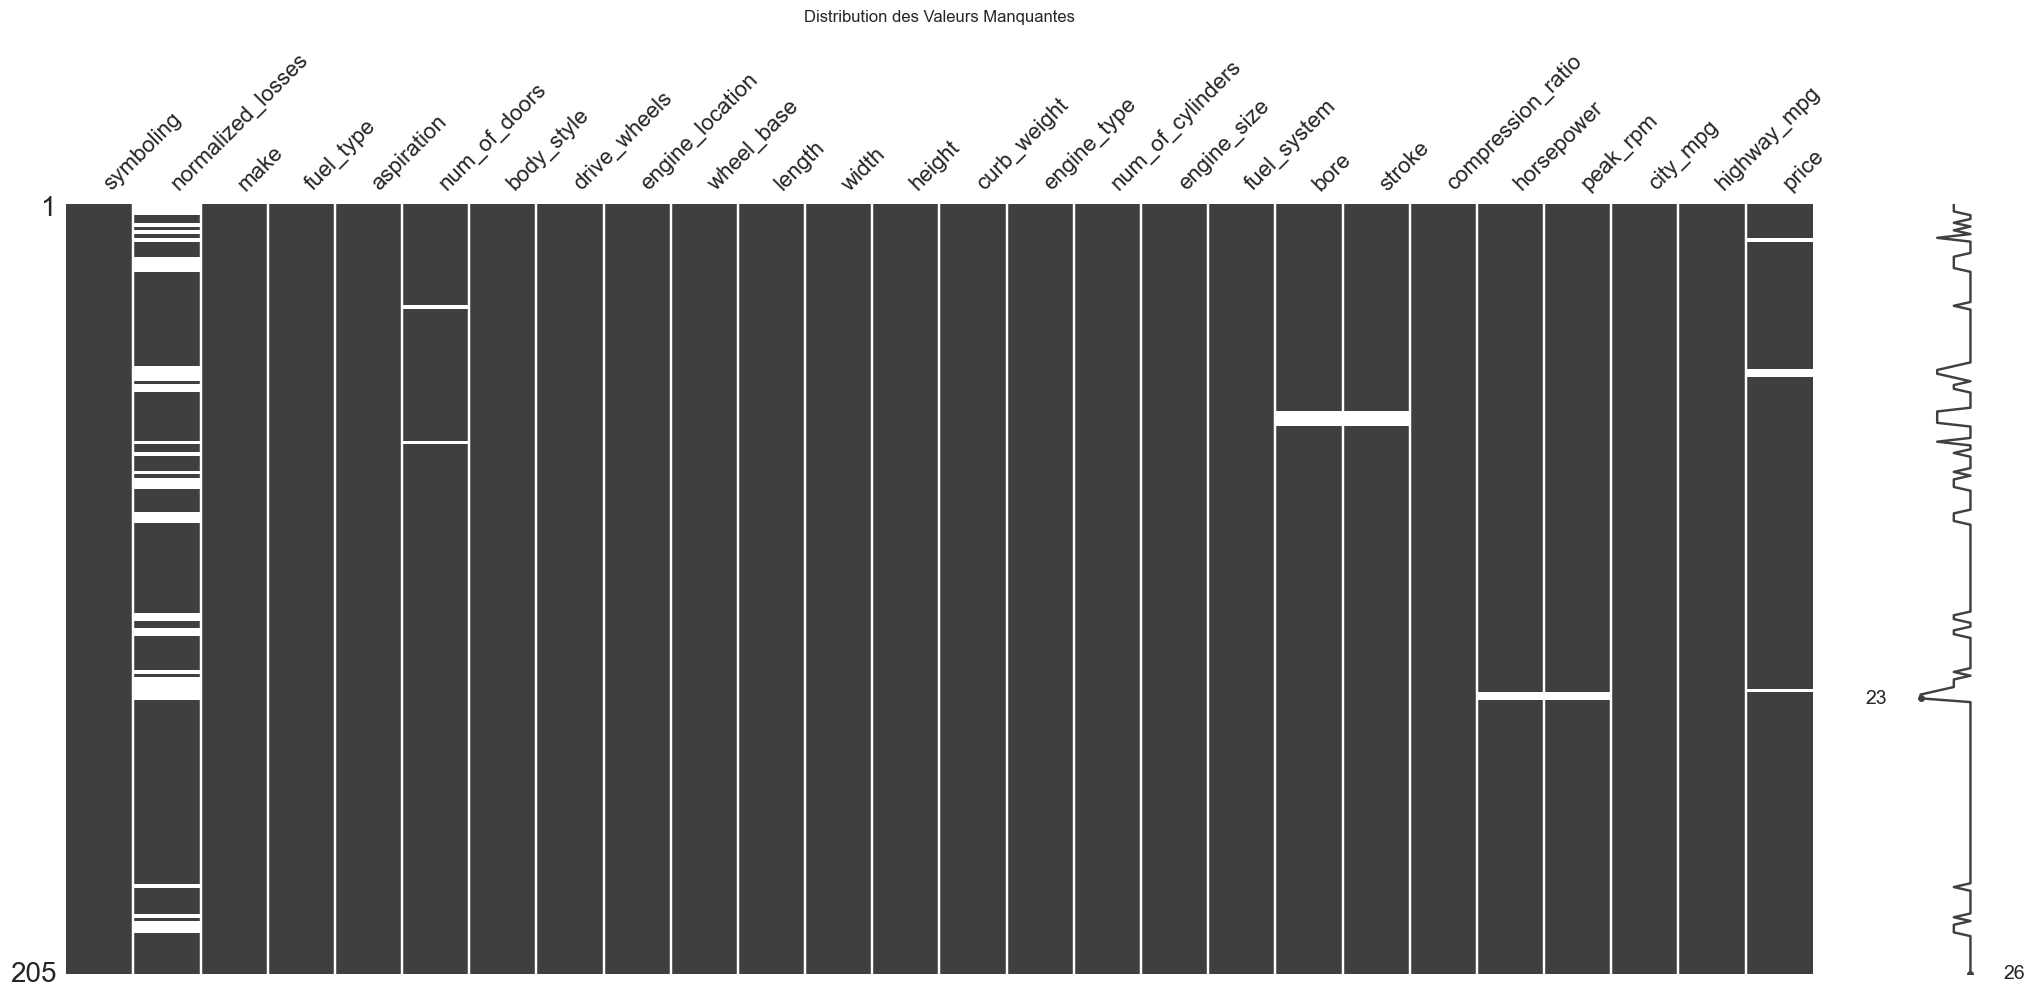

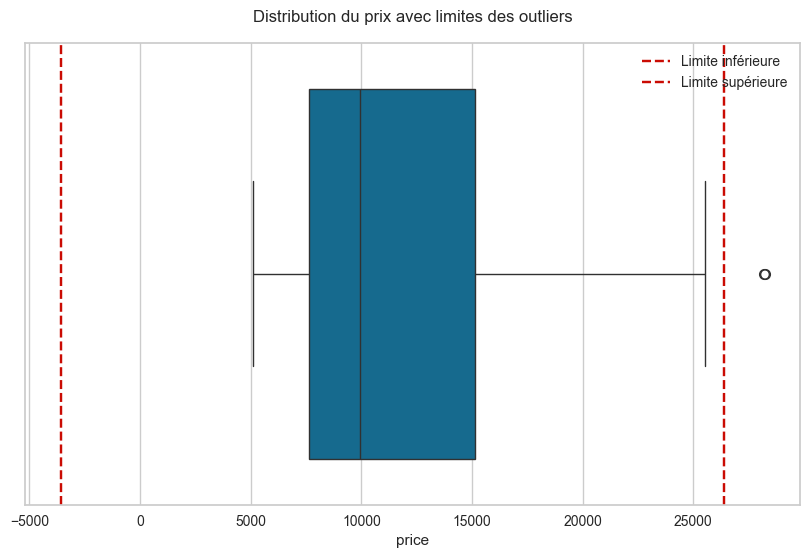

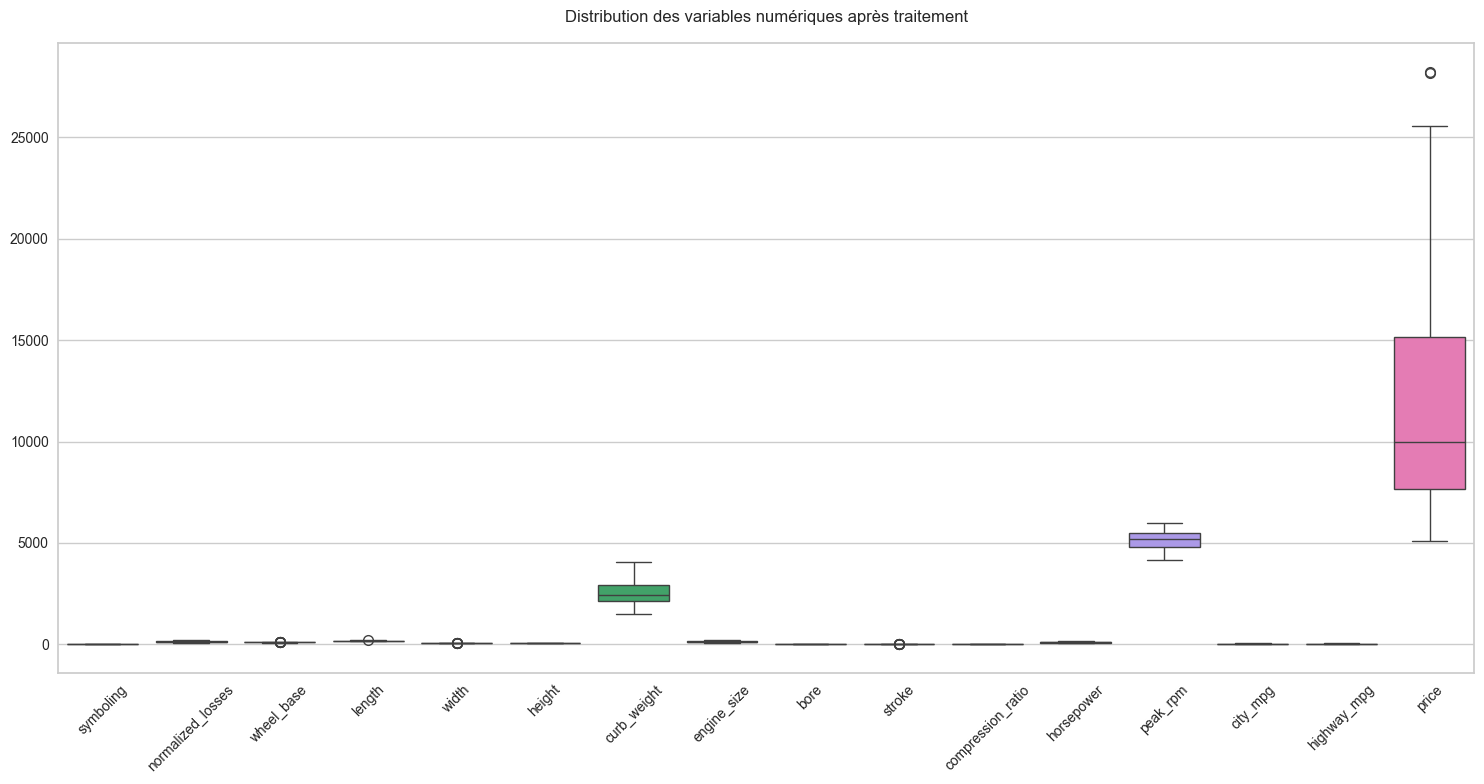


Résumé du nettoyage:
- Valeurs manquantes initiales: 59
- Valeurs manquantes après traitement: 157
- Colonnes supprimées: Aucune

Détection des outliers:
- normalized_losses: 1 outliers (0.49%)
- wheel_base: 3 outliers (1.46%)
- length: 1 outliers (0.49%)
- width: 8 outliers (3.90%)
- engine_size: 10 outliers (4.88%)
- stroke: 20 outliers (9.76%)
- compression_ratio: 28 outliers (13.66%)
- horsepower: 6 outliers (2.93%)
- peak_rpm: 2 outliers (0.98%)
- city_mpg: 2 outliers (0.98%)
- highway_mpg: 3 outliers (1.46%)
- price: 14 outliers (6.83%)

Dimensions de X_train: (149, 25)
Dimensions de X_test: (38, 25)
📊 Début de l'évaluation des modèles...

🔍 Traitement du modèle Ridge...
✅ Ridge - R² Test: 0.862 | RMSE Test: 0.13

🔍 Traitement du modèle Lasso...
✅ Lasso - R² Test: 0.887 | RMSE Test: 0.12

🔍 Traitement du modèle RandomForest...
✅ RandomForest - R² Test: 0.821 | RMSE Test: 0.15

🔍 Traitement du modèle LinearRegression...
✅ LinearRegression - R² Test: 0.755 | RMSE Test: 0.18

🔍 Tra

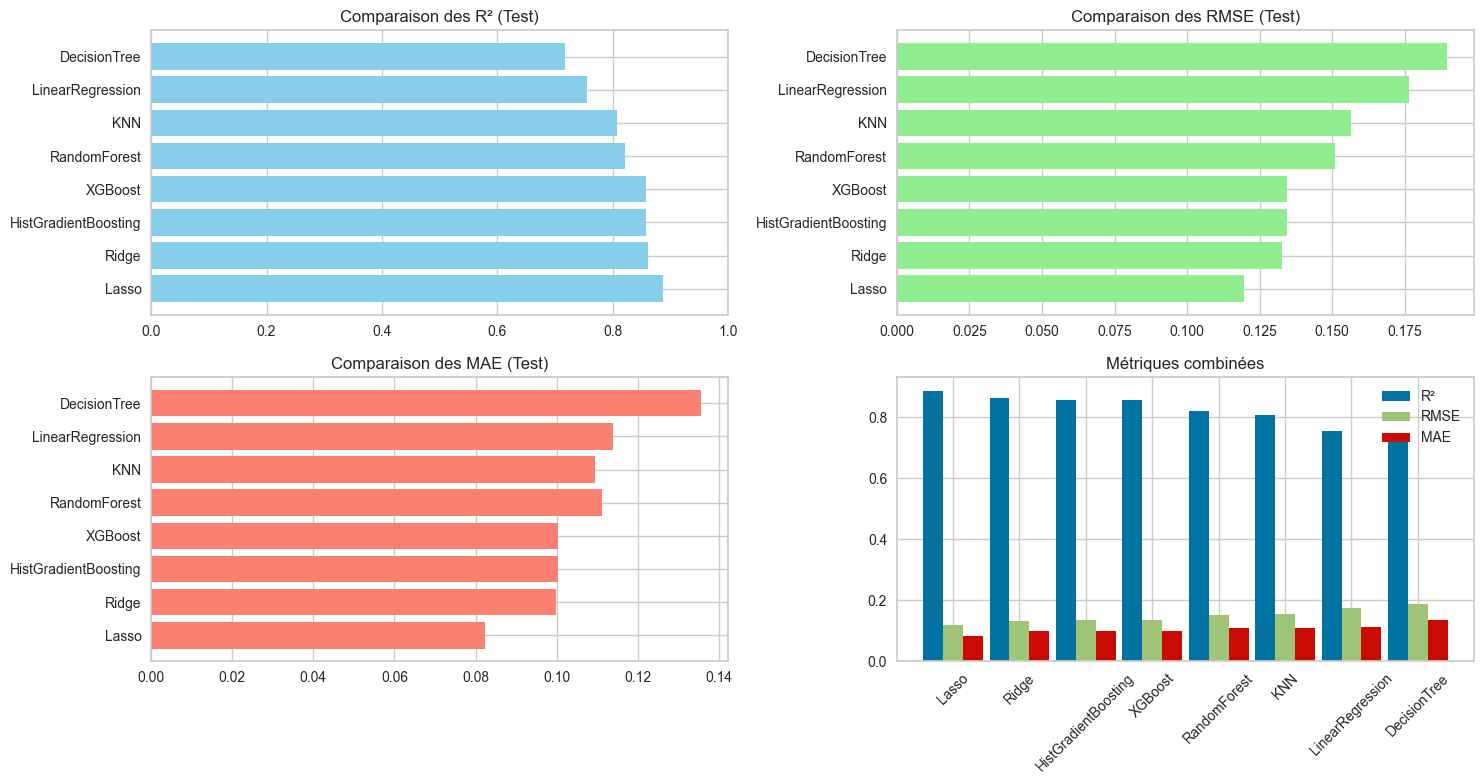


📈 Analyse des prédictions et erreurs...

🔍 Top 10 des pires prédictions (toutes colonnes) :
     symboling        make fuel_type aspiration  num_of_doors body_style  \
136          3        saab       gas      turbo           2.0  hatchback   
64           0       mazda       gas        std           4.0  hatchback   
111          0      peugot       gas        std           4.0      sedan   
166          1      toyota       gas        std           2.0  hatchback   
176         -1      toyota       gas        std           4.0      sedan   
193          0  volkswagen       gas        std           4.0      wagon   
28          -1       dodge       gas        std           4.0      wagon   
5            2        audi       gas        std           2.0      sedan   
179          3      toyota       gas        std           2.0  hatchback   
190          3  volkswagen       gas        std           2.0  hatchback   

    drive_wheels  wheel_base  length  width  height  curb_weight engin

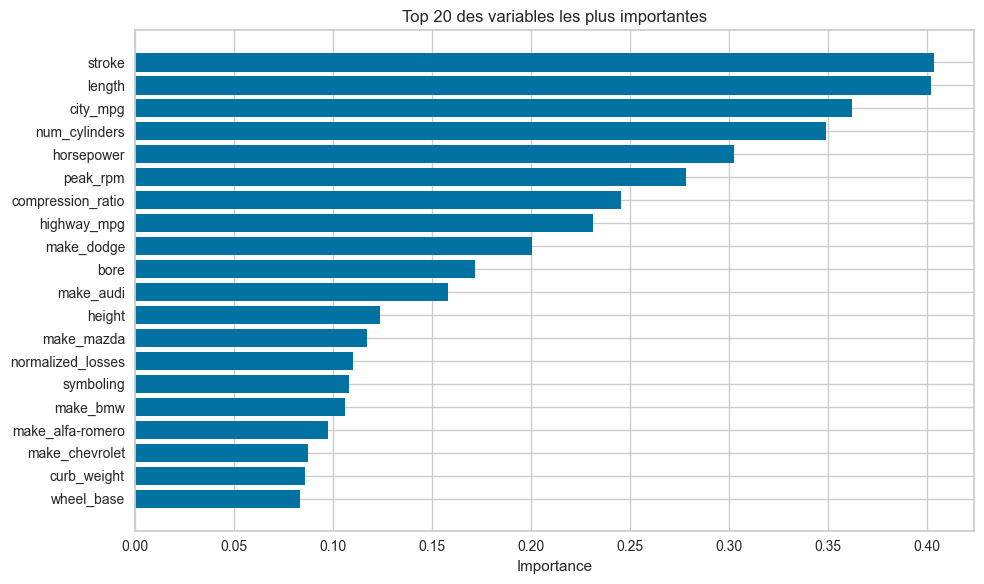

Modèle sauvegardé avec succès!

Meilleur modèle: Lasso
Type de modèle: LassoCV

Métriques complètes:
                   0
Modèle         Lasso
MAPE_train   0.00784
MAPE_test   0.009025
RMSE_train   0.09044
MAE_train   0.072722
R²_train    0.952705
RMSE_test   0.119673
MAE_test    0.082267
R²_test     0.887393
Type         LassoCV


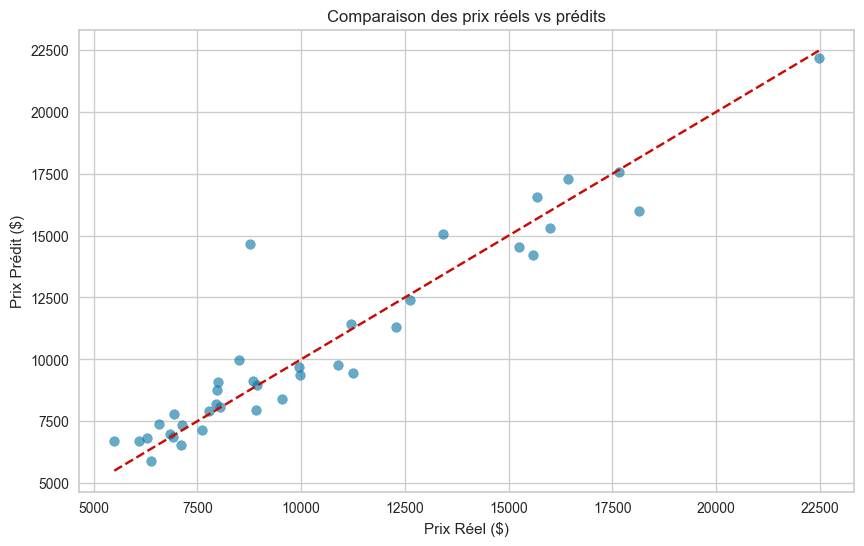

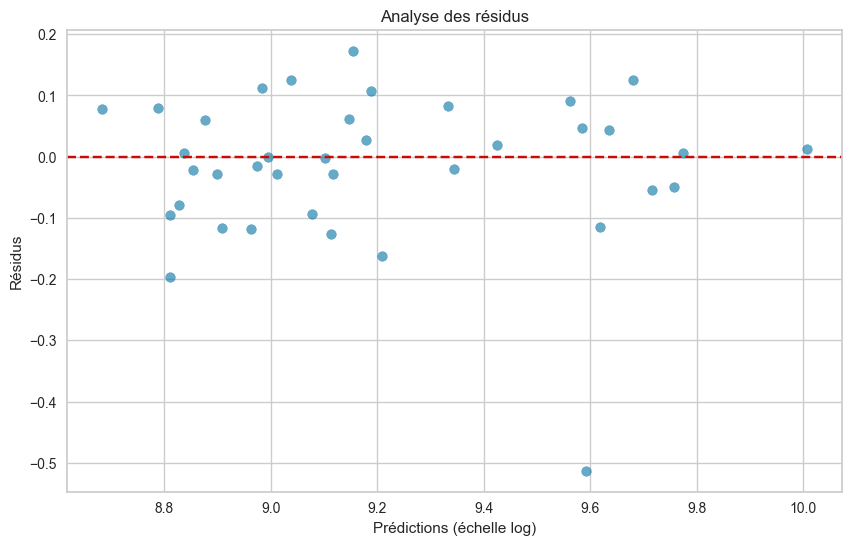

In [39]:
# 12.Execution
if __name__ == "__main__":
    chemin = Path("C:/Users/HP/Desktop/S4/Machine_Learning/Mon_projet_Machine_Learning/mabase/Automobile_data.csv")
    data, all_results, best_model_name, best_pipeline, model_info, X_test, y_test, analysis_df = main(chemin)
    
    print(f"\nMeilleur modèle: {best_model_name}")
    print(f"Type de modèle: {type(best_pipeline.named_steps['model']).__name__}")
    print(f"\nMétriques complètes:")
    print(pd.DataFrame([all_results[best_model_name]]).T)
    
    # Visualisation des prédictions
    try:
        test_predictions = best_pipeline.predict(X_test)
        
        plt.figure(figsize=(10, 6))
        plt.scatter(np.expm1(y_test), np.expm1(test_predictions), alpha=0.6)
        plt.plot([min(np.expm1(y_test)), max(np.expm1(y_test))], 
                 [min(np.expm1(y_test)), max(np.expm1(y_test))], 'r--')
        plt.xlabel('Prix Réel ($)')
        plt.ylabel('Prix Prédit ($)')
        plt.title('Comparaison des prix réels vs prédits')
        plt.show()
        
        # Analyse des résidus
        residuals = y_test - test_predictions
        plt.figure(figsize=(10, 6))
        plt.scatter(test_predictions, residuals, alpha=0.6)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Prédictions (échelle log)')
        plt.ylabel('Résidus')
        plt.title('Analyse des résidus')
        plt.show()
        
    except Exception as e:
        print(f"Erreur lors de la visualisation: {str(e)}")